In [1]:
import matplotlib.pyplot as plt

'''
Implementing the closed for matting in pyTorch to utilize GPU.
'''

'\nImplementing the closed for matting in pyTorch to utilize GPU.\n'

In [4]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided
import scipy.sparse
import scipy.sparse.linalg

In [5]:
def _rolling_block(A, block=(3, 3)):
    """Applies sliding window to given matrix."""
    shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
    strides = (A.strides[0], A.strides[1]) + A.strides
    return as_strided(A, shape=shape, strides=strides)

def get_laplacian(img: np.ndarray, mask=None, eps: float =10**(-7), win_rad: int =1):
    """Computes Matting Laplacian for a given image.

    Args:
        img: 3-dim numpy matrix with input image
        mask: mask of pixels for which Laplacian will be computed.
            If not set Laplacian will be computed for all pixels.
        eps: regularization parameter controlling alpha smoothness
            from Eq. 12 of the original paper. Defaults to 1e-7.
        win_rad: radius of window used to build Matting Laplacian (i.e.
            radius of omega_k in Eq. 12).
    Returns: sparse matrix holding Matting Laplacian.
    """

    win_size = (win_rad * 2 + 1) ** 2
    h, w, d = img.shape
    # Number of window centre indices in h, w axes
    c_h, c_w = h - 2 * win_rad, w - 2 * win_rad
    win_diam = win_rad * 2 + 1

    indsM = np.arange(h * w).reshape((h, w))
    ravelImg = img.reshape(h * w, d)
    win_inds = _rolling_block(indsM, block=(win_diam, win_diam))

    win_inds = win_inds.reshape(c_h, c_w, win_size)
    if mask is not None:
        mask = cv2.dilate(
            mask.astype(np.uint8),
            np.ones((win_diam, win_diam), np.uint8)
        ).astype(bool)
        win_mask = np.sum(mask.ravel()[win_inds], axis=2)
        win_inds = win_inds[win_mask > 0, :]
    else:
        win_inds = win_inds.reshape(-1, win_size)

    
    winI = ravelImg[win_inds]

    win_mu = np.mean(winI, axis=1, keepdims=True)
    win_var = np.einsum('...ji,...jk ->...ik', winI, winI) / win_size - np.einsum('...ji,...jk ->...ik', win_mu, win_mu)

    A = win_var + (eps/win_size)*np.eye(3)
    B = (winI - win_mu).transpose(0, 2, 1)
    X = np.linalg.solve(A, B).transpose(0, 2, 1)
    vals = np.eye(win_size) - (1.0/win_size)*(1 + X @ B)

    nz_indsCol = np.tile(win_inds, win_size).ravel()
    nz_indsRow = np.repeat(win_inds, win_size).ravel()
    nz_indsVal = vals.ravel()
    L = scipy.sparse.coo_matrix((nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h*w, h*w))

    # rewrite L in CSR format
    L = scipy.sparse.csr_matrix((nz_indsVal, nz_indsCol, np.arange(0, nz_indsVal.shape[0] + 1, win_size)), shape=(h*w, h*w))
    return L

In [6]:
class ClosedFormMatting():
    def __init__(self):
        pass
    def matting_with_scribbles(self, image, scribbles,  map_const, confidence = 100.0, device='cuda'):
        '''
        image is h x w x 3,
        scribbles : h x w x 3 - our mask coming from borders
        confidence: lambda ?
        map_const: Values which are not expected to change. Basically, our borders.
        '''
        image = torch.tensor(image, device=device, requires_grad=False)
        map_const = torch.tensor(map_const, device=device, requires_grad=False)
        scribbles = torch.tensor(scribbles, device=device, requires_grad=False)
        
        # Prior is 0.5 where everything matches. 1 where scribbling was white, and 0 where scribble was black.
        # const_map is where scribble was done
        
        # I believe we get prior beforehand here. Need to check.
        prior = scribbles
        output = self.matting_with_prior(image, prior, confidence, map_const)
        return output
    
    def matting_with_prior(self, image, prior, lamb, map_const):
        '''
        prior: becomes h x w 
        '''
        # Why it is constant inverse?
        laplacian = get_laplacian(image, map_const)
        # print('got')
        print(float(map_const.numel() **2))
        capital_D_lamb = torch.diag(lamb * map_const.reshape(-1))
        
        solved = torch.linalg.solve(laplacian + capital_D_lamb, (prior * lamb * map_const).reshape(-1) )
        # Not sure what is going here
        alpha = torch.min(torch.max(solved.reshape(prior.shape), dim=0), dim=1)
        return alpha    
    
    
    

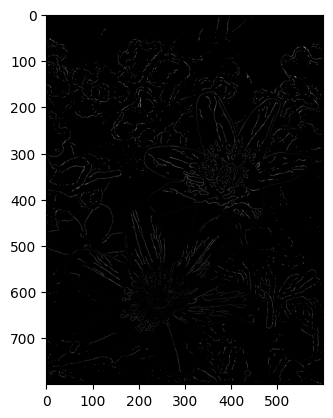

In [7]:
contrast_image = cv2.imread('../SpectrumContrast/D.png',0)
plt.imshow(contrast_image,cmap='gray')
plt.show()

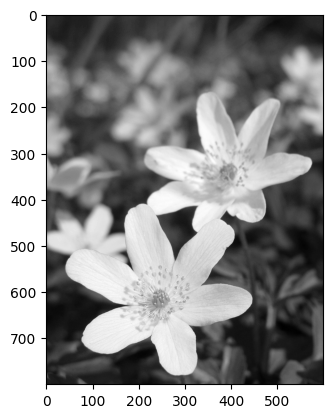

In [8]:
image = cv2.imread('../SpectrumContrast/inputflower.png',0)
plt.imshow(image,cmap='gray')
plt.show()

In [9]:
const_map = np.zeros_like(contrast_image)
const_map[contrast_image != 0] = 1

matting = ClosedFormMatting()
matting.matting_with_scribbles(image=image, scribbles=contrast_image, map_const=const_map)

AssertionError: Torch not compiled with CUDA enabled